In [1]:
import math
import glob
import random
import pandas as pd
import numpy as np
import wfdb as wf
from tqdm import tqdm
import csv 
from scipy.signal import resample

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import Dataset, TensorDataset, DataLoader
from torchsummary import summary
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import normalize, MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sn
import copy

# import imblearn
# from imblearn.over_sampling import SMOTE
# from imblearn.combine import SMOTETomek
from collections import Counter

In [34]:
# file path, place download data in ../data/mit-bih/ folder 
path = '../data/mit-bih/'
csv_path = '../data/mit-bih-csv/'

In [28]:
# ------------------------------------------------------------
# (do some processing) and generate csv file from .dat and .attr
def generate_csv(path, csv_path):
    ids = get_file(path, '*.dat')
    
    # check if folder exists
    if not os.path.exists(csv_path):
        os.mkdir(csv_path)
    
    for sig_id in ids:
        sig_id = str(sig_id)
        print(sig_id)
        signal = wf.rdsamp(path+sig_id)[0]
        annotation = wf.rdann(path+sig_id, 'atr')

        sample = np.expand_dims(annotation.sample, axis=1)
        symbol = np.array(annotation.symbol)
        symbol = np.expand_dims(symbol, axis=1)
        annots = np.hstack((sample, symbol))

        # save to csv, no precessing at the moment
        np.savetxt(csv_path+sig_id+'.csv', signal, delimiter=',')
        np.savetxt(csv_path+sig_id+'annotations.csv', annots, delimiter=',', fmt='%s')
        
# ------------------------------------------------------------
# get file name from path
def get_file(path, extension="*annotations.csv"):
    file_glob = glob.glob(path + extension)

    file_paths = []
    for g in file_glob:
        # extract only the file name, e.g. 100
        file_path = g[len(path):][:-len(extension)+1]
        file_paths.append(int(file_path))

    file_paths = sorted(file_paths)
    return file_paths

# ------------------------------------------------------------
# read csv data ECG data including signals and annotations from path
def read_data(path, channel):
    # channel=0 for II signal, channel=1 for I signal
    signals = []
    annotations = []
    for sig_id in ids:
        sig_id = str(sig_id)
        signal = pd.read_csv(path+sig_id+'.csv', header=None)
        annotation = pd.read_csv(path+sig_id+'annotations.csv', header=None, quoting=csv.QUOTE_NONE)
        signal = signal.loc[:, channel]

        signals.append(signal.to_numpy())
        annotations.append(annotation.to_numpy())
    return signals, annotations

# ------------------------------------------------------------
# filter out paced heartbeat (102, 104, 107, 217)
def filter_record(signals, annotations, ids):
    paced_pn = [102, 104, 107, 217]
    new_ids = []
    
    new_signals = []
    new_annotations = []
    for i, pid in enumerate(ids):
        if pid not in paced_pn:
            new_ids.append(pid)
            new_signals.append(signals[i])
            new_annotations.append(annotations[i])
            
    return new_signals, new_annotations, new_ids

# ------------------------------------------------------------
# extract beats from the signal using the annotations
# beat extraction using equal size of window to the left and right
# also extract beat trio (neighbors)
# also process the annotation symbol into five classes: (N[0], S[1], V[2], F[3], Q[4])
# equal window size to the left and right(in second)
def extract_beats(signals, annotations, window_size=0.5, sampling=128):
    
    # normalize signal
    mn = np.array(signals).min()
    mx = np.array(signals).max()
    me = np.array(signals).mean()
    std = np.array(signals).std()
    # signals = (signals - mn)/(mx - mn) # to [0, 1]
    signals = (signals - me)/std # normal standardization
    
    window = int(window_size * 360) # 360 frequency sampling rate
    beats = []
    beats_annot = []
    for i, annots in enumerate(annotations):
        beats_i = []
        beats_annot_i = []
        for d in annots:
            r_peak = d[0]
            symbol = d[1]
            
            if symbol == '+':
                continue

            if r_peak-window>0 and r_peak+window<648000:
                # extract beat and beat trio
                beat = np.array(signals[i][r_peak-window: r_peak+window])

                # process labels into five classes
                if symbol=='N' or symbol=='L' or symbol=='R'or symbol=='e' or symbol=='j':
                    symbol = 0
                if symbol=='A' or symbol=='a' or symbol=='J' or symbol=='S':
                    symbol = 1
                if symbol=='V' or symbol=='E':
                    symbol = 2
                if symbol=='F':
                    symbol = 3
                if symbol=='/' or symbol=='f' or symbol=='Q':
                    symbol = 4
                
                if symbol in [0, 1, 2, 3, 4]:
                    process_annot = np.array([r_peak, symbol])
                    beats_i.append(beat)
                    beats_annot_i.append(process_annot)
        beats.append(beats_i)
        beats_annot.append(beats_annot_i)
    return beats, beats_annot

# ------------------------------------------------------------
def resample_beat(beats, sampling):
    rs_beats = []
    for beat in beats:
        pbeats = np.stack(beat, axis=0)
        rsbeats = resample(pbeats, sampling, axis=1)
        rsbeats = np.expand_dims(rsbeats, axis=1)
        rs_beats.append(rsbeats)
    return rs_beats

# ------------------------------------------------------------
# extract patient specific data (t = 5 mins)
def split_data_timefime(beats, annotations, time=5, trio=False):
    beats_first = []
    beats_last = []
    annots_first = []
    annots_last = []

    for i, annot in enumerate(annotations):
        beats_first_i = []
        beats_last_i = []
        annots_first_i = []
        annots_last_i = []
        
        for j, d in enumerate(annot):
            
            first_five_min = time*60*360
            t = int(d[0])

            if t < first_five_min:
                beats_first_i.append(beats[i][j])
                annots_first_i.append(d)
            else:
                beats_last_i.append(beats[i][j])
                annots_last_i.append(d)
        
        # convert to numpy
        beats_first_i = np.stack(beats_first_i)
        beats_last_i = np.stack(beats_last_i)

        beats_first.append(beats_first_i)
        beats_last.append(beats_last_i)
        annots_first.append(annots_first_i)
        annots_last.append(annots_last_i)
        
    return beats_first, annots_first, beats_last, annots_last

# ------------------------------------------------------------
def extract_beat_trio(beats, annots):
    window_size = int(beats[0][0].shape[0]/2)
    nbeats = []
    nannots = []
    beats_trio = []
    for i, beat in enumerate(beats):
        beat_trio = []
        
        for j, b in enumerate(beat):
            # skip the first and last (cannot extract beat trio)
            if j == 0 or j==len(beat)-1:
                continue
            trio = np.hstack((beat[j-1][window_size:], beat[j], beat[j+1][:window_size]))
            beat_trio.append(trio)
            
        nbeats.append(beat[1:-1])
        nannots.append(annots[i][1:-1])
        beats_trio.append(np.array(beat_trio))
    return nbeats, beats_trio, nannots
        
# ------------------------------------------------------------
def annots_to_label(annotations):
    labels = []
    for annot in annotations:
        pannot = np.stack(annot, axis=0)
        labels.append(pannot[:, 1])
    return labels

# ------------------------------------------------------------
# get subtask data based on patients ids list
def get_task_data(beats, labels, task_ids, ids):
    tx = []
    ty = []
    indexes = {}
    for i, paid in enumerate(ids):
        indexes[paid] = i
    
    for pid in task_ids:
        index = indexes[pid]
        tx.append(beats[index])
        ty.append(labels[index])
    return tx, ty
    
# ------------------------------------------------------------
# extract 245 representative beats from first 20 records
def get_common_data(beats, labels):
    # select only from the first 20 records
    sample_beats = np.vstack(beats[:20])
    sample_labels = np.hstack(labels[:20])
    
    # 75 from N, S, V; 13 from F; 7 from Q
    N_idx = np.where(sample_labels == 0)[0]
    S_idx = np.where(sample_labels == 1)[0]
    V_idx = np.where(sample_labels == 2)[0]
    F_idx = np.where(sample_labels == 3)[0]
    Q_idx = np.where(sample_labels == 4)[0]
    
    selected_N = random.sample(N_idx.tolist(), 75)
    selected_S = random.sample(S_idx.tolist(), 75)
    selected_V = random.sample(V_idx.tolist(), 75)
    selected_F = random.sample(F_idx.tolist(), 13)
    selected_Q = random.sample(Q_idx.tolist(), 7)
    
    common_beats = []
    common_labels = []
    
    common_beats.append(sample_beats[selected_N])
    common_beats.append(sample_beats[selected_S])
    common_beats.append(sample_beats[selected_V])
    common_beats.append(sample_beats[selected_F])
    common_beats.append(sample_beats[selected_Q])
    common_labels.append(sample_labels[selected_N])
    common_labels.append(sample_labels[selected_S])
    common_labels.append(sample_labels[selected_V])
    common_labels.append(sample_labels[selected_F])
    common_labels.append(sample_labels[selected_Q])
    
    common_beats = np.vstack(common_beats)
    common_labels = np.hstack(common_labels)
    return common_beats, common_labels

# ------------------------------------------------------------
def up_down_sampling(beats, labels, smote=False, average=False):
    udbeats = []
    udlabels = []
    
    for i, label in enumerate(labels):
        if smote:
            pass
            # oversample = SMOTE()
            # udbeat, udlabel = oversample.fit_resample(beats[i], label)
        else:
            if average:
                n = label.shape[0]
                n_average = int(n/5)
                udbeat = []
                udlabel = []
                for j in range(5):
                    mask = np.where(label == j)
                    if len(mask) > 0:
                        resample_mask = resample(mask, n_average)
                        udbeat.append(beats[i][mask])
                        udlabel.append(labels[i][mask])
                    else:
                        udbeat.append(beats[i])
                        udlabel.append(labels[i])
                udbeat = np.vstack(udbeat)
                udlabel = np.hstack(udlabel)
            else:
                n = label.shape[0]
                n0 = sum(label == 0)
                nr = n - n0
                n_down = int(n * 0.5)

                # downsampling class "0"
                if n_down < n0 and nr > 0:
                    down_indices = np.random.choice(np.where(label == 0)[0], n_down)
                    beat0 = beats[i][down_indices]
                    label0 = labels[i][down_indices]

                    # repeat other classes labels for n times
                    n_repeat = math.floor(n_down/nr)
                    remainder = int(n_down - nr *(n_repeat))
                    labelr_mask = np.where(label != 0)[0]

                    if (n_repeat >= 1):
                        repeat_mask = list(labelr_mask) * n_repeat
                        if (remainder > 0):
                            remainder_selection = np.random.choice(labelr_mask, remainder)
                            repeat_mask.extend(list(remainder_selection))
                        beatr = beats[i][repeat_mask]
                        labelr = labels[i][repeat_mask]

                        udbeat = np.concatenate((beat0, beatr), axis=0)
                        udlabel = np.concatenate((label0, labelr))
                    else:
                        udbeat = beat0
                        udlabel = label0
                else:
                    udbeat = beats[i]
                    udlabel = labels[i]

        udbeats.append(udbeat)
        udlabels.append(udlabel)
    return udbeats, udlabels

## Read and process data

In [31]:
# generate csv file (COMMENT code below if skip generating csv)
generate_csv(path, csv_path)

In [29]:
ids = get_file(csv_path)

In [6]:
# read data from csv file
signals, annotations = read_data(csv_path, channel=0)

# find out the "paced" heartbeats (102, 104, 107, and 217) and exclude them (44 records left)
nsignals, nannotations, nid = filter_record(signals, annotations, ids)

# ------------------------------------------------------------
# normalize signals and extract beats
beats, beats_annot = extract_beats(nsignals, nannotations, window_size=0.5)

# ------------------------------------------------------------
# get the patient-specific data (first 5 mins)
# pbeats: n_users * n_beats * n_channel * n_sampling
pbeats, pannots, tbeats, tannots = split_data_timefime(beats, beats_annot, time=5, trio=True)

# ------------------------------------------------------------
# extract beats
# beats and annotations of patients in the first 5 mins
pbeats, pbeats_trio, pannots = extract_beat_trio(pbeats, pannots)

# ------------------------------------------------------------
# beats and annotations of patients in the last 25 mins
tbeats, tbeats_trio, tannots = extract_beat_trio(tbeats, tannots)

# convert annotation to labels
plabels = annots_to_label(pannots)
tlabels = annots_to_label(tannots)

# ------------------------------------------------------------
# resample beats and beats trio 
pbeats = resample_beat(pbeats, sampling=128)
pbeats_trio = resample_beat(pbeats_trio, sampling=128)

tbeats = resample_beat(tbeats, sampling=128)
tbeats_trio = resample_beat(tbeats_trio, sampling=128)

# ------------------------------------------------------------
# join beats and beats trio 
pbeats = [np.concatenate((pbeats[i], pbeats_trio[i]), axis=1) for i in range(len(pbeats))]
tbeats = [np.concatenate([tbeats[i], tbeats_trio[i]], axis=1) for i in range(len(tbeats))]

In [7]:
# join all train and test beats and annotations
all_beats = [np.concatenate((pbeats[i], tbeats[i]), axis=0) for i in range(len(pbeats))]
all_labels = [np.concatenate((plabels[i], tlabels[i]), axis=0) for i in range(len(plabels))]

# extract common beats
common_beats, common_labels = get_common_data(all_beats, all_labels)

39376
189
1273
13
7


In [8]:
print(all_beats[0].shape)
print(all_labels[0].shape)
print(pbeats[0].shape)
print(plabels[0].shape)
print(tbeats[0].shape)
print(tlabels[0].shape)
print(common_beats.shape)
print(common_labels.shape)

(2259, 2, 128)
(2259,)
(368, 2, 128)
(368,)
(1891, 2, 128)
(1891,)
(245, 2, 128)
(245,)


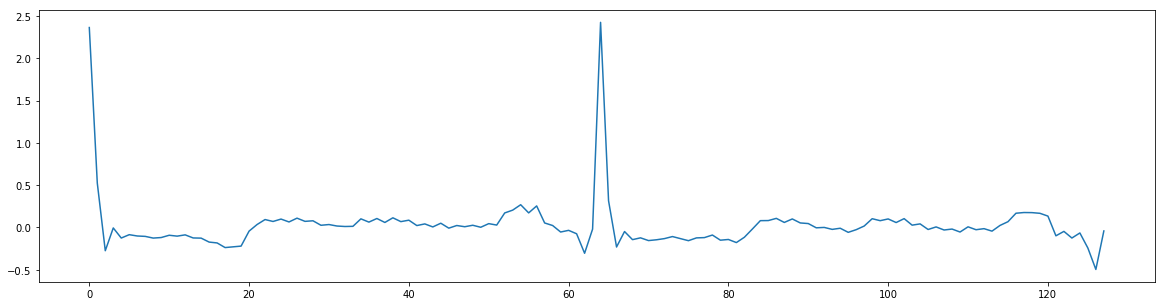

In [9]:
plt.figure(figsize = (20,5))
plt.plot(all_beats[0][0][1])

## Train data and Test data

[0 1 2 3 4]
[75 75 75 13  7]


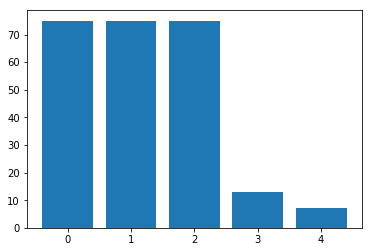

Counter({0: 364, 1: 4})
[0 1 2 3 4]
[89637  2757  6977   800    15]


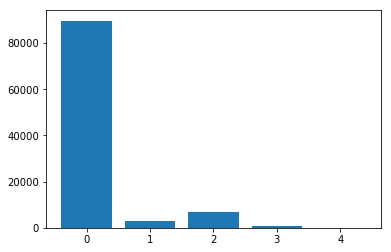

Counter({0: 364, 1: 4})


In [10]:
# train
beats_tr = pbeats
labels_tr = plabels

# test
beats_ts = tbeats
labels_ts = tlabels

# join the beats_tr with common beats
beats_tr_common, labels_tr_common = [], []
for i, beats in enumerate(beats_tr):
    beats_tr_common.append(np.vstack((beats, common_beats)))
    labels_tr_common.append(np.hstack((labels_tr[i], common_labels)))

# downsampling and upsampling training beats to handle imbalance class
beats_tr, labels_tr = up_down_sampling(beats_tr, labels_tr, smote=False, average=True)
beats_tr_common, labels_tr_common = up_down_sampling(beats_tr_common, labels_tr_common, smote=False, average=True)

# add common beats to patients training set (TODO remove this later, only for testing)
# beats_tr, labels_tr = beats_tr_common, labels_tr_common

In [11]:
def prepare_train_loader(x, y):
    x_train = torch.from_numpy(x).double()
    y_train = torch.from_numpy(y).long()
    train_dataset = TensorDataset(x_train, y_train)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    return train_loader

# torch test loader
def prepare_test_loader(tx, ty):
    tx = np.vstack(tx)
    x_test = torch.from_numpy(tx).double()
    y_test = torch.from_numpy(np.hstack(ty)).long()
    test_dataset = TensorDataset(x_test, y_test)
    test_loader = DataLoader(test_dataset, batch_size=32)
    return test_loader

In [12]:
# (Dataset 1) 11 common for VEB (200, 202, 210, 213, 214, 219, 221, 228, 231, 233, and 234), 
# 14 common for SVEB (212, 222, and 232)
veb_ids = [200, 202, 210, 213, 214, 219, 221, 228, 231, 233, 234]
sveb_ids = [200, 202, 210, 213, 214, 219, 221, 228, 231, 233, 234, 212, 222, 232]
tx_veb, ty_veb = get_task_data(beats_ts, labels_ts, veb_ids, nid)
tx_sveb, ty_sveb = get_task_data(beats_ts, labels_ts, sveb_ids, nid)

# (Dataset 2) 24 (200-)
tx_24, ty_24 = beats_ts[-24:], labels_ts[-24:]

# (Dataset 3) all records
tx_44, ty_44 = beats_ts, labels_ts 

In [13]:
# torch train loader
n_patients = len(beats_tr)
train_loaders = []

for i in range(n_patients):
    train_loader = prepare_train_loader(beats_tr[i], labels_tr[i])
    train_loaders.append(train_loader)
    
common_loader = prepare_train_loader(common_beats, common_labels)
all_loader = prepare_train_loader(np.vstack(all_beats), np.hstack(all_labels))

# test loader
veb_loader = prepare_test_loader(tx_veb, ty_veb)
sveb_loader = prepare_test_loader(tx_sveb, ty_sveb)
task24_loader = prepare_test_loader(tx_24, ty_24)
task44_loader = prepare_test_loader(tx_44, ty_44)

# prepare test loader (patient-specific)
veb_loaders = [prepare_train_loader(tx_veb[i], ty_veb[i]) for i in range(len(tx_veb))]
sveb_loaders = [prepare_train_loader(tx_sveb[i], ty_sveb[i]) for i in range(len(tx_sveb))]
task24_loaders = [prepare_train_loader(tx_24[i], ty_24[i]) for i in range(len(tx_24))]
task44_loaders = [prepare_train_loader(tx_44[i], ty_44[i]) for i in range(len(tx_44))]

# combine all 3 test loaders in one
test_loaders = [veb_loader, sveb_loader, task24_loader, task44_loader]
test_loaderss = [veb_loaders, sveb_loaders, task24_loaders, task44_loaders]

In [36]:
# index of patients w.r.t each test set
nid_dict = dict(zip(nid, range(len(nid))))

veb_idx = [nid_dict[i] for i in veb_ids]
sveb_idx = [nid_dict[i] for i in sveb_ids]
tx24_idx = [nid_dict[i] for i in nid[-24:]]
tx44_idx = [i for i in range(len(nid))]
idxs = [veb_idx, sveb_idx, tx24_idx, tx44_idx]

[0 1 2 3 4]
[75 75 75 13  7]


<BarContainer object of 5 artists>

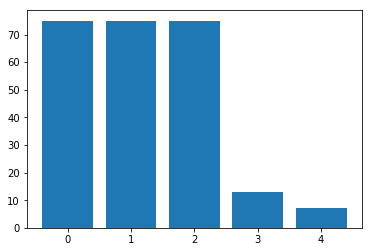

In [75]:
# visualization of common labels histogram
a = np.hstack(common_labels)
(unique, counts) = np.unique(a, return_counts=True)
print(unique)
print(counts)

plt.bar(np.arange(len(counts)), height=counts)

## CNN Model

In [21]:
class CNN1D(nn.Module):
    
    # the proposed model is as described as below
    '''
        The 1-D CNN used in all experiments has 32 and 16 neurons on the ﬁrst- and 
        second-hidden CNN layers and ten neurons on the hidden MLP layer. The output (MLP) 
        layer size is 5 which is the number of beat classes and the input (CNN) layer size is 
        either 2 (base) or 4 (extended) according to the choice of raw data representation. 
        For 64 and 128 sample beat representations, the kernel sizes are set to 9 and 15, 
        and the subsampling factors are set to 4 and 6, respectively. As a result, in the 
        proposed adaptive CNN implementation, the subsampling factors for the last CNN layers are 
        automatically set to 6 and 5, respectively.
    '''
    
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv1d(2, 16, kernel_size=9, padding=7) # kernel=9,15？ (for sampling_rate=64,128)
        self.pool1 = nn.MaxPool1d(6)
        self.pool2 = nn.MaxPool1d(5)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv1d(16, 32, kernel_size=9, padding=7)
        self.conv3 = nn.Conv1d(32, 32, kernel_size=5, padding=3)
        self.fc1 = nn.Linear(160, 10)
        self.fc2 = nn.Linear(10, 5)
        self.dropout = nn.Dropout(p=0.25)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool1(x)
#         x = F.dropout(0.25)

        x = self.conv3(x)
        x = self.relu(x)
        x = self.pool2(x)
#         x = F.dropout(0.25)
#         print(x.size())
        
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = self.fc2(x)
        return x

In [23]:
# visualize model
m = CNN1D()
summary(m, (2, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1              [-1, 16, 134]             304
              ReLU-2              [-1, 16, 134]               0
           Dropout-3              [-1, 16, 134]               0
            Conv1d-4              [-1, 32, 140]           4,640
              ReLU-5              [-1, 32, 140]               0
         MaxPool1d-6               [-1, 32, 23]               0
            Conv1d-7               [-1, 32, 25]           5,152
              ReLU-8               [-1, 32, 25]               0
         MaxPool1d-9                [-1, 32, 5]               0
           Linear-10                   [-1, 10]           1,610
           Linear-11                    [-1, 5]              55
Total params: 11,761
Trainable params: 11,761
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/ba

In [70]:
def train(model, train_loader, common_loader, patient_epochs, common_epochs, optimizer, lr, verbose=0):
    epoch_loss = []
    
    # learning rate decay
    decay_factor = 0.1
    patient_scheduler = StepLR(optimizer, step_size=1, gamma=1-decay_factor)
    shallow_scheduler = StepLR(optimizer, step_size=1, gamma=1-decay_factor*3)
    mul_scheduler = StepLR(optimizer, step_size=1, gamma=1+decay_factor*3)
    
    criterion = nn.CrossEntropyLoss()
    
    for epoch in range(patient_epochs):
        
        if common_loader is not None:
            
            # shallow training for common dataset
            for ce in range(common_epochs):

                # validate the classification error for early stop (>3% error)
                with torch.no_grad():
                    predictions = []
                    true_labels = []
                    for i, data in enumerate(common_loader):
                        beats, labels = data
                        pred = model(beats)
                        _, pred = torch.max(pred, 1)
                        predictions.extend(pred.tolist())
                        true_labels.extend(labels.tolist())
                    acc = accuracy_score(true_labels, predictions)

                # early stop at 3% classification error
                if acc >= 0.97:
                    print('early stop at BP iteration =', ce) 
                    break
                else:
                    for i, data in enumerate(common_loader):
                        beats, labels = data

                        optimizer.zero_grad()
                        pred = model(beats)
                        loss = criterion(pred, labels)
                        loss.backward()
                        optimizer.step()
         
        if train_loader is not None:
            # patient training using patient dataset
            batch_loss = []
            for i, data in enumerate(train_loader):
                beats, labels = data

                optimizer.zero_grad()
                pred = model(beats)
                loss = criterion(pred, labels)
                loss.backward()
                optimizer.step()
                batch_loss.append(loss.item())

            # learning rate decay
            patient_scheduler.step()

            cur_loss = sum(batch_loss)/len(batch_loss)
            if verbose != 0:
                print('epoch {} loss = {}'.format(epoch, cur_loss))
            epoch_loss.append(cur_loss)
        
    return model, epoch_loss
            
def evaluate(model, test_loader):
    predictions = []
    preds_prob = []
    true_labels = []
    
    with torch.no_grad():
        for i, data in enumerate(test_loader):
            beats, labels = data
            pred = model(beats)
            _, prediction = torch.max(F.softmax(pred, 1), 1)
            preds_prob.extend(np.array(pred))
            predictions.extend(prediction.tolist())
            true_labels.extend(labels.tolist())
    
    preds_prob = np.array(preds_prob)

    return predictions, true_labels, preds_prob

def train_models(train_loaders, common_loader, n, train_user=True, common=False, fed=False):
    models = []
    
    def FedAvg(w):
        w_avg = copy.deepcopy(w[0])
        for k in w_avg.keys():
            for i in range(1, len(w)):
                w_avg[k] += w[i][k]
            w_avg[k] = torch.div(w_avg[k], len(w))
        return w_avg
        
    # training model using FedAvg
    if fed:
        n_rounds = 30
        model = CNN1D().double()
        for r in range(n_rounds):
            
            print('fed round', r)
            w_locals = []
            m = max(int(0.5 * n), 1)
            idxs_users = np.random.choice(range(n), m, replace=False)
            
            for i in idxs_users:
                print('training for user =', i+1)

                # train model
                local_model = copy.deepcopy(model)
                lr = 0.001
                patient_epochs = 1
                common_epochs = 30

                # when use SGD optimizer always give class "0" predictions?
                optimizer = torch.optim.Adam(local_model.parameters(), lr=lr)

                if train_user:
                    train_loader = train_loaders[i]
                else:
                    train_loader = train_loaders

                if common:
                    model, epoch_loss = train(local_model, None, train_loader, patient_epochs, common_epochs, optimizer, lr, verbose=0)
                else:
                    model, epoch_loss = train(local_model, train_loader, common_loader, patient_epochs, common_epochs, optimizer, lr, verbose=0)
                w_locals.append(local_model.state_dict())
            
            # fedavg
            w_glob = FedAvg(w_locals)
            
            model.load_state_dict(w_glob)
        return model
    
    # train model centralize
    else:
        for i in range(n):
            print('training for user =', i+1)

            # train model
            model = CNN1D().double()
            lr = 0.001
            patient_epochs = 10
            common_epochs = 50

            # when use SGD optimizer always give class "0" predictions?
            optimizer = torch.optim.Adam(model.parameters(), lr=lr)

            if train_user:
                train_loader = train_loaders[i]
            else:
                train_loader = train_loaders

            if common:
                model, epoch_loss = train(model, None, train_loader, patient_epochs, common_epochs, optimizer, lr, verbose=0)
            else:
                model, epoch_loss = train(model, train_loader, common_loader, patient_epochs, common_epochs, optimizer, lr, verbose=0)
            models.append(model)

    return models

In [24]:
# train models using each patients data individually (separately)
n = len(all_labels)
models = train_models(train_loaders, common_loader, n, train_user=True)

training for user = 1
early stop at BP iteration = 12
early stop at BP iteration = 6
early stop at BP iteration = 2
early stop at BP iteration = 3
early stop at BP iteration = 2
early stop at BP iteration = 1
early stop at BP iteration = 0
early stop at BP iteration = 2
early stop at BP iteration = 2
training for user = 2
early stop at BP iteration = 49
early stop at BP iteration = 8
early stop at BP iteration = 6
early stop at BP iteration = 3
early stop at BP iteration = 2
early stop at BP iteration = 1
early stop at BP iteration = 1
early stop at BP iteration = 2
early stop at BP iteration = 0
early stop at BP iteration = 1
training for user = 3
early stop at BP iteration = 11
early stop at BP iteration = 2
early stop at BP iteration = 10
early stop at BP iteration = 0
early stop at BP iteration = 1
early stop at BP iteration = 1
early stop at BP iteration = 5
early stop at BP iteration = 0
early stop at BP iteration = 1
training for user = 4
early stop at BP iteration = 18
early st

In [25]:
# train model using all patients data
all_model = train_models(all_loader, None, n=1, train_user=False)

training for user = 1


In [71]:
# train model in federated learning fashion
fed_model = train_models(train_loaders, common_loader, n, train_user=True, fed=True)

fed round 0
training for user = 34
training for user = 42
training for user = 27
early stop at BP iteration = 10
training for user = 2
early stop at BP iteration = 6
training for user = 10
early stop at BP iteration = 7
training for user = 14
early stop at BP iteration = 4
training for user = 37
early stop at BP iteration = 3
training for user = 1
early stop at BP iteration = 4
training for user = 22
early stop at BP iteration = 2
training for user = 43
early stop at BP iteration = 5
training for user = 26
early stop at BP iteration = 6
training for user = 12
early stop at BP iteration = 2
training for user = 31
early stop at BP iteration = 1
training for user = 21
early stop at BP iteration = 3
training for user = 11
early stop at BP iteration = 1
training for user = 38
early stop at BP iteration = 1
training for user = 33
early stop at BP iteration = 1
training for user = 35
early stop at BP iteration = 2
training for user = 19
early stop at BP iteration = 1
training for user = 36
ea

---------------------VEB---------------------
VEB result
ACC = 97.78, TPR = 93.71, TNR = 98.33, PPV = 88.26

SVEB result
ACC = 98.75, TPR = 10.36, TNR = 99.52, PPV = 15.75

average confusion matrix


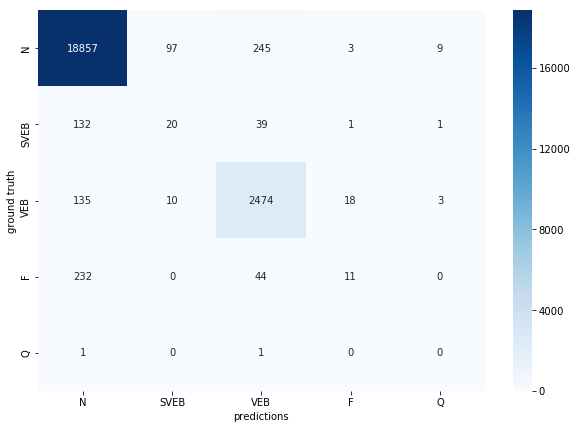

---------------------SVEB---------------------
VEB result
ACC = 98.16, TPR = 94.47, TNR = 98.54, PPV = 86.99

SVEB result
ACC = 96.83, TPR = 55.15, TNR = 99.28, PPV = 81.71

average confusion matrix


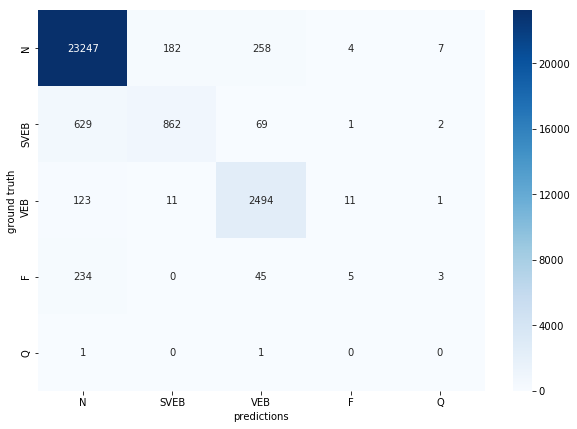

---------------------Dataset2---------------------
VEB result
ACC = 96.85, TPR = 89.15, TNR = 97.67, PPV = 80.47

SVEB result
ACC = 96.77, TPR = 42.93, TNR = 99.42, PPV = 78.55

average confusion matrix


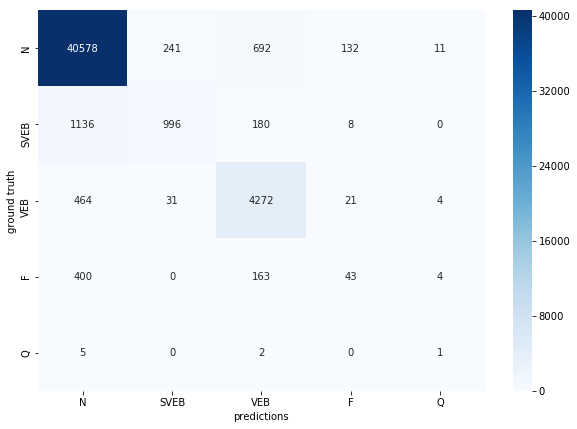

---------------------Dataset3---------------------
VEB result
ACC = 97.99, TPR = 90.44, TNR = 98.57, PPV = 82.67

SVEB result
ACC = 97.53, TPR = 45.12, TNR = 99.14, PPV = 61.55

average confusion matrix


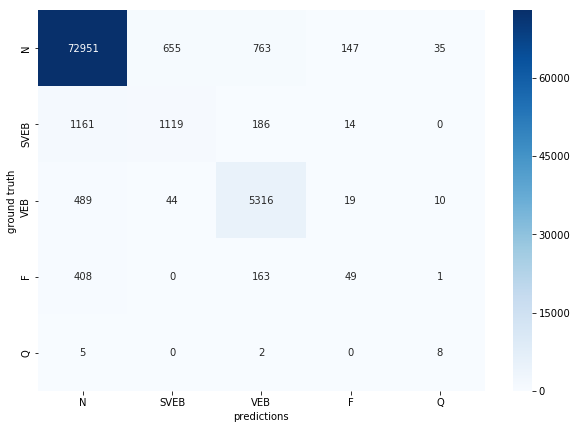

In [72]:
# evaluate fed model and evaluate
fed_model = [fed_model]
evaluate_result(fed_model, test_loaders)

In [54]:
# ------------------------------------------------------------
def compute_result(pred, lab, target):
    predictions = np.array(pred)
    labels = np.array(lab) 

    # accuracy, sensitivity, specificity, positive predictivity
    tp = sum(np.logical_and(predictions == target, labels == target))
    fp = sum(np.logical_and(predictions == target, labels != target))
    tn = sum(np.logical_and(predictions != target, labels != target))
    fn = sum(np.logical_and(predictions != target, labels == target))

    acc = 0 if (tp + fp + tn + fn)==0 else (tp + tn) / (tp + fp + tn + fn)
    sen = 0 if (tp + fn) == 0 else tp / (tp + fn)
    spe = 0 if (tn + fp) == 0 else tn / (tn + fp)
    ppv = 0 if (tp + fp) == 0 else tp / (tp + fp)

    return acc, sen, spe, ppv

# ------------------------------------------------------------
# compute mean for veb
def mean_matrics(accs, sens, spes, ppvs, k):
    n = len(accs)
    acc, sen, spe, ppv = accs[0][k], sens[0][k], spes[0][k], ppvs[0][k]

    for i in range(1, n):
        acc += accs[i][k]
        sen += sens[i][k]
        spe += spes[i][k]
        ppv += ppvs[i][k]

    acc = acc / len(accs)
    sen = sen / len(sens)
    spe = spe / len(spes)
    ppv = ppv / len(ppvs)
    
    return acc, sen, spe, ppv

# ------------------------------------------------------------
# evaluate many models on the whole test dataset
def evaluate_result(models, test_loaders):
    n = len(models)

    loader_info = ['VEB', 'SVEB', 'Dataset2', 'Dataset3']
    for j, test_loader in enumerate(test_loaders):
        print('---------------------{}---------------------'.format(loader_info[j]))
        
        preds_prob = []
        preds = []
        labels = []
        accs = []
        sens = []
        spes = []
        ppvs = []
        
        for i in range(n):
            pred, lab, pred_prob = evaluate(models[i], test_loader)
            acc_sveb, sen_sveb, spe_sveb, ppv_sveb = compute_result(pred, lab, target=1)
            acc_veb, sen_veb, spe_veb, ppv_veb = compute_result(pred, lab, target=2)
            
            if i == 0:
                labs = lab
                
            preds.extend(pred)
            labels.extend(lab)
            preds_prob.append(pred_prob)
            accs.append([acc_veb, acc_sveb])
            sens.append([sen_veb, sen_sveb])
            spes.append([spe_veb, spe_sveb])
            ppvs.append([ppv_veb, ppv_sveb])
            
        if n > 1:
            # ensemble predictions
            preds_prob = np.array(preds_prob)
            summed = np.sum(preds_prob, axis=0)
            result = np.argmax(summed, axis=1)
            en_acc_sveb, en_sen_sveb, en_spe_sveb, en_ppv_sveb = compute_result(result, labs, target=1)
            en_acc_veb, en_sen_veb, en_spe_veb, en_ppv_veb = compute_result(result, labs, target=2)
            en_cm = confusion_matrix(lab, result, labels=[0, 1, 2, 3, 4])
        
        # veb
        acc, sen, spe, ppv = mean_matrics(accs, sens, spes, ppvs, k=0)
        print('VEB result')
        print('ACC = {:.2f}, TPR = {:.2f}, TNR = {:.2f}, PPV = {:.2f}'
              .format(acc*100, sen*100, spe*100, ppv*100))
        
        if n > 1:
            print('VEB result (ensemble)')
            print('ACC = {:.2f}, TPR = {:.2f}, TNR = {:.2f}, PPV = {:.2f}'
                  .format(en_acc_veb*100, en_sen_veb*100, en_spe_veb*100, en_ppv_veb*100))
        
        # sveb
        acc, sen, spe, ppv = mean_matrics(accs, sens, spes, ppvs, k=1)
        print('\nSVEB result')
        print('ACC = {:.2f}, TPR = {:.2f}, TNR = {:.2f}, PPV = {:.2f}'
              .format(acc*100, sen*100, spe*100, ppv*100))
        
        lab = ['N', 'SVEB', 'VEB', 'F', 'Q']
        
        if n > 1:
            print('SVEB result (ensemble)')
            print('ACC = {:.2f}, TPR = {:.2f}, TNR = {:.2f}, PPV = {:.2f}'
                  .format(en_acc_sveb*100, en_sen_sveb*100, en_spe_sveb*100, en_ppv_sveb*100))
            
            print('\nensemble confusion matrix')
            df_cm = pd.DataFrame(en_cm, range(5), range(5))
            plt.figure(figsize = (10,7))
            plt.xlabel('predictions')
            plt.ylabel('ground truth')
            ax = sn.heatmap(df_cm, annot=True, cmap='Blues', fmt='d', xticklabels=lab, yticklabels=lab)
            ax.set(xlabel='predictions', ylabel='ground truth')
            plt.show()
        
        print('\naverage confusion matrix')
        cm = confusion_matrix(labels, preds, labels=[0, 1, 2, 3, 4])
        cm = cm/n
        cm = cm.astype(int)
        df_cm = pd.DataFrame(cm, range(5), range(5))
        plt.figure(figsize = (10,7))
        ax = sn.heatmap(df_cm, annot=True, cmap='Blues', fmt='d', xticklabels=lab, yticklabels=lab)
        ax.set(xlabel='predictions', ylabel='ground truth')
        plt.show()
        
# ------------------------------------------------------------
# evaluate each models against patient dataset separately, i.e. model4 -> test set of patient index 4
def evaluate_result2(models, test_loaders, idxs, many=True):
    n = len(models)

    loader_info = ['VEB', 'SVEB', 'Dataset2', 'Dataset3']
    for j, test_loader in enumerate(test_loaders):
        print('---------------------{}---------------------'.format(loader_info[j]))
        
        preds_prob = []
        preds = []
        labels = []
        accs = []
        sens = []
        spes = []
        ppvs = []
        idx = idxs[j]
        
        for i in range(len(idx)):
            cur_idx = idx[i]
            pred, lab, pred_prob = evaluate(models[cur_idx], test_loader[i])
            acc_sveb, sen_sveb, spe_sveb, ppv_sveb = compute_result(pred, lab, target=1)
            acc_veb, sen_veb, spe_veb, ppv_veb = compute_result(pred, lab, target=2)
            
            if i == 0:
                labs = lab
                
            preds.extend(pred)
            labels.extend(lab)
            preds_prob.append(pred_prob)
            accs.append([acc_veb, acc_sveb])
            sens.append([sen_veb, sen_sveb])
            spes.append([spe_veb, spe_sveb])
            ppvs.append([ppv_veb, ppv_sveb])
        
        
        if many:
            print('\n============= mean metrics =============')
            # veb
            acc, sen, spe, ppv = mean_matrics(accs, sens, spes, ppvs, k=0)
            print('VEB result')
            print('ACC = {:.2f}, TPR = {:.2f}, TNR = {:.2f}, PPV = {:.2f}'
                  .format(acc*100, sen*100, spe*100, ppv*100))

            # sveb
            acc, sen, spe, ppv = mean_matrics(accs, sens, spes, ppvs, k=1)
            print('\nSVEB result')
            print('ACC = {:.2f}, TPR = {:.2f}, TNR = {:.2f}, PPV = {:.2f}'
                  .format(acc*100, sen*100, spe*100, ppv*100))
        
        lab = ['N', 'SVEB', 'VEB', 'F', 'Q']
        
        
        print('\n============= metrics based on predictions =============')
        acc_sveb, sen_sveb, spe_sveb, ppv_sveb = compute_result(preds, labels, target=1)
        acc_veb, sen_veb, spe_veb, ppv_veb = compute_result(preds, labels, target=2)
        
        print('VEB result')
        print('ACC = {:.2f}, TPR = {:.2f}, TNR = {:.2f}, PPV = {:.2f}'
              .format(acc_veb*100, sen_veb*100, spe_veb*100, ppv_veb*100))
        
        print('\nSVEB result')
        print('ACC = {:.2f}, TPR = {:.2f}, TNR = {:.2f}, PPV = {:.2f}'
              .format(acc_sveb*100, sen_sveb*100, spe_sveb*100, ppv_sveb*100))
        
        print('\naverage confusion matrix')
        cm = confusion_matrix(labels, preds, labels=[0, 1, 2, 3, 4])
        cm = cm
        cm = cm.astype(int)
        df_cm = pd.DataFrame(cm, range(5), range(5))
        plt.figure(figsize = (10,7))
        ax = sn.heatmap(df_cm, annot=True, cmap='Blues', fmt='d', xticklabels=lab, yticklabels=lab)
        ax.set(xlabel='predictions', ylabel='ground truth')
        plt.show()

---------------------VEB---------------------

============= mean metrics =============
VEB result
ACC = 97.34, TPR = 75.09, TNR = 97.87, PPV = 68.61

SVEB result
ACC = 98.02, TPR = 6.90, TNR = 98.72, PPV = 8.77

============= metrics based on predictions =============
VEB result
ACC = 97.37, TPR = 94.58, TNR = 97.74, PPV = 84.87

SVEB result
ACC = 98.02, TPR = 12.95, TNR = 98.76, PPV = 8.36

average confusion matrix


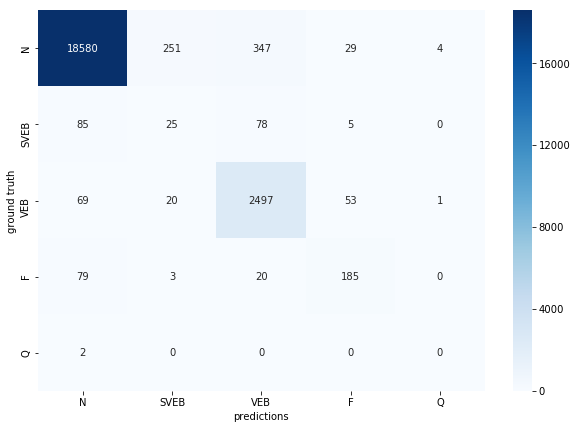

---------------------SVEB---------------------

============= mean metrics =============
VEB result
ACC = 97.70, TPR = 58.70, TNR = 98.10, PPV = 53.75

SVEB result
ACC = 97.46, TPR = 22.01, TNR = 98.32, PPV = 20.49

============= metrics based on predictions =============
VEB result
ACC = 97.69, TPR = 94.77, TNR = 98.00, PPV = 83.01

SVEB result
ACC = 97.44, TPR = 81.19, TNR = 98.40, PPV = 74.82

average confusion matrix


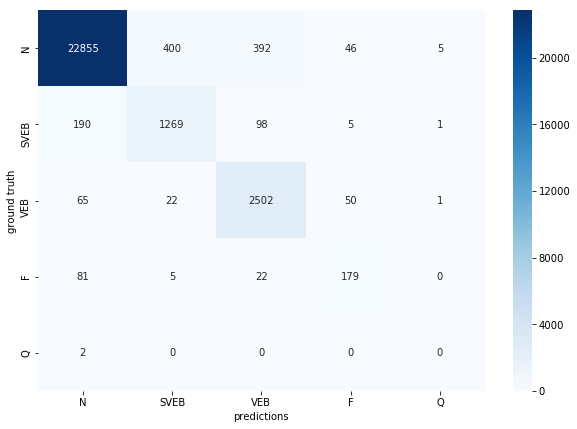

---------------------Dataset2---------------------

============= mean metrics =============
VEB result
ACC = 97.06, TPR = 63.44, TNR = 98.18, PPV = 56.45

SVEB result
ACC = 96.76, TPR = 21.12, TNR = 98.48, PPV = 23.85

============= metrics based on predictions =============
VEB result
ACC = 97.25, TPR = 88.11, TNR = 98.24, PPV = 84.31

SVEB result
ACC = 96.79, TPR = 61.55, TNR = 98.53, PPV = 67.36

average confusion matrix


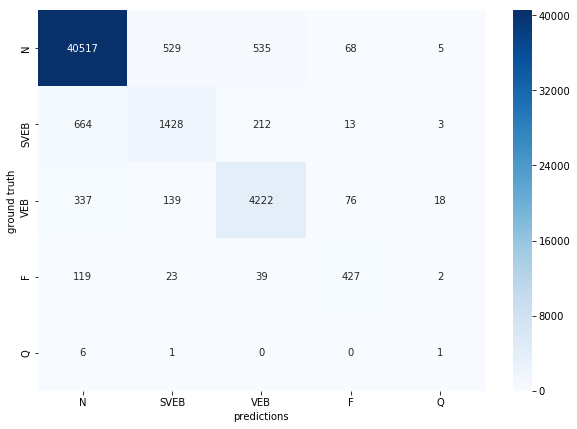

---------------------Dataset3---------------------

============= mean metrics =============
VEB result
ACC = 98.24, TPR = 60.81, TNR = 98.93, PPV = 57.10

SVEB result
ACC = 96.86, TPR = 24.39, TNR = 97.80, PPV = 22.91

============= metrics based on predictions =============
VEB result
ACC = 98.23, TPR = 89.45, TNR = 98.90, PPV = 85.97

SVEB result
ACC = 97.00, TPR = 63.55, TNR = 98.03, PPV = 49.62

average confusion matrix


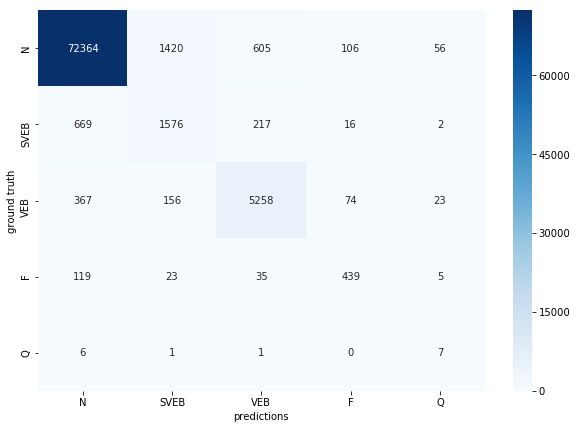

In [52]:
# evaluate the models on each patients test set
evaluate_result2(models, test_loaderss, idxs)

---------------------VEB---------------------
VEB result
ACC = 99.57, TPR = 98.18, TNR = 99.76, PPV = 98.22

SVEB result
ACC = 99.53, TPR = 61.14, TNR = 99.87, PPV = 80.27

average confusion matrix


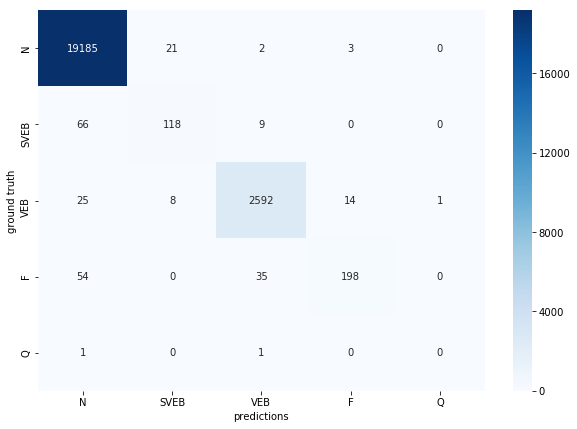

---------------------SVEB---------------------
VEB result
ACC = 99.67, TPR = 98.22, TNR = 99.82, PPV = 98.26

SVEB result
ACC = 99.33, TPR = 90.72, TNR = 99.84, PPV = 97.06

average confusion matrix


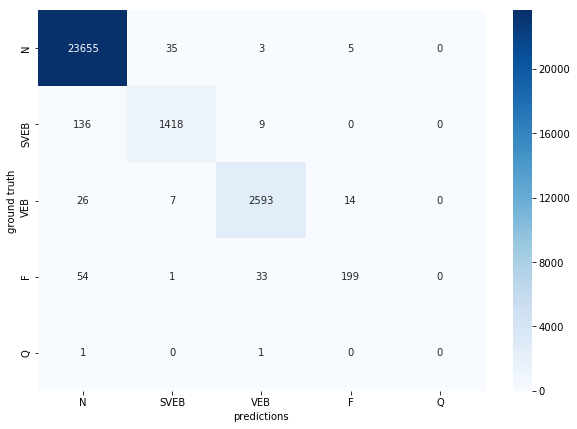

---------------------Dataset2---------------------
VEB result
ACC = 99.65, TPR = 98.50, TNR = 99.78, PPV = 97.95

SVEB result
ACC = 99.42, TPR = 90.43, TNR = 99.86, PPV = 97.04

average confusion matrix


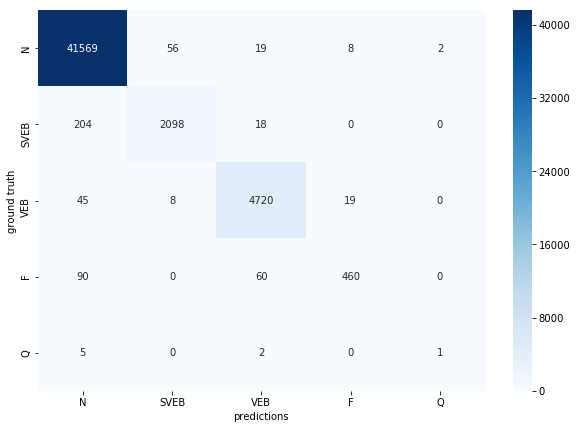

---------------------Dataset3---------------------
VEB result
ACC = 99.74, TPR = 98.26, TNR = 99.85, PPV = 98.05

SVEB result
ACC = 99.59, TPR = 89.35, TNR = 99.90, PPV = 96.60

average confusion matrix


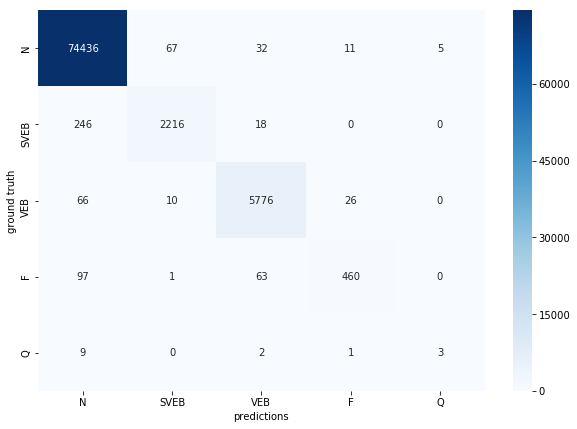

In [56]:
# evaluate model on the whole test set
evaluate_result(all_model, test_loaders)